In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
time = []
flow = []
tot_1 = []
tot_2 = []
analog_2 = []
with open('B1586024706369.json') as file:
    data = json.load(file)
    for i in np.arange(0,len(data)-1): 
        time.append(data[i]['timeStamp'])
        flow.append(data[i]['idflowmeter'])
        tot_1.append(data[i]['tot1'])
        tot_2.append(data[i]['tot2'])
        analog_2.append(data[i]['analog2'])

In [3]:
flows_data = pd.DataFrame(
    {'Times': time,
     'Total_1' : tot_1,
     'Total_2'  : tot_2,
     'Analog_2' : analog_2
    })


In [12]:
flows_data = flows_data.drop(labels = [27,28,29,30])

In [103]:
flows_data[0:len(flows_data)-1]

,Times,Total_1,Total_2,Analog_2
0,2018-11-23 07:03:00,0.00,0.00,0.00
1,2018-11-23 07:04:00,0.00,0.00,0.00
2,2018-11-23 07:06:00,0.00,0.00,0.00
3,2018-11-23 07:09:00,0.00,0.00,0.00
4,2018-11-23 07:10:00,0.00,0.00,0.00
...,...,...,...,...
1395738,2020-04-01 14:03:00,977427.00,-4713.21,1.54
1395739,2020-04-01 14:04:00,977427.62,-4713.21,1.54
1395740,2020-04-01 14:05:00,977428.25,-4713.21,1.54
1395741,2020-04-01 14:06:00,977428.88,-4713.21,1.54


In [6]:
#df = flows_data.set_index('Times').resample('1H').pad()
#print (df)
flows_data['Times'] = pd.to_datetime(flows_data['Times'], errors = 'coerce')

In [7]:
flows_data = flows_data.set_index('Times')

In [8]:
hour_summary1 = flows_data.Total_1.resample('60T').sum()
hour_summary2 = flows_data.Total_2.resample('60T').sum()

# or easier 
# flows_data_resampled = flows_data.resample('60T').sum()

In [9]:
hour_summary1['hour'] = flows_data.Total_1.resample('60T').transform('sum')
hour_summary2['hour'] = flows_data.Total_2.resample('60T').transform('sum')

# flows_data_resampled['hour'] = flows_data.resample('60T').transform('sum')

In [10]:
hour_summary1

Times
2018-11-23 07:00:00                                                    0
2018-11-23 08:00:00                                                 7.05
2018-11-23 09:00:00                                              2726.88
2018-11-23 10:00:00                                              8078.47
2018-11-23 11:00:00                                              10920.5
                                             ...                        
2020-04-01 11:00:00                                            5.864e+07
2020-04-01 12:00:00                                          5.86422e+07
2020-04-01 13:00:00                                          5.86444e+07
2020-04-01 14:00:00                                          8.79685e+06
hour                   Times
NaT                           NaN
2018-1...
Name: Total_1, Length: 11889, dtype: object

In [11]:
hour_summary2

Times
2018-11-23 07:00:00                                                    0
2018-11-23 08:00:00                                                    0
2018-11-23 09:00:00                                                    0
2018-11-23 10:00:00                                                    0
2018-11-23 11:00:00                                                    0
                                             ...                        
2020-04-01 11:00:00                                              -282793
2020-04-01 12:00:00                                              -282793
2020-04-01 13:00:00                                              -282793
2020-04-01 14:00:00                                             -42418.9
hour                   Times
NaT                         NaN
2018-11-...
Name: Total_2, Length: 11889, dtype: object

In [12]:
import matplotlib.pyplot as plt

In [13]:
value_t1 = []
value_t2 = []

flows_data['value_t1'] = flows_data['Total_1'].shift(-1) - flows_data['Total_1']
flows_data['value_t2'] = flows_data['Total_2'].shift(-1) - flows_data['Total_2']
# I1 = range(0, len(flows_data['Total_1'])-1)

# for i in I1:
#    value_t1.append(flows_data['Total_1'][i+1]-flows_data['Total_1'][i])
    
# I2 = range(0, len(flows_data['Total_2'])-1)

# for i in I2:
#    value_t2.append(flows_data['Total_2'][i+1]-flows_data['Total_2'][i])

###############################################################################

# sensor_1 = []
# sensor_2 = []

# I1 = range(0, len(hour_summary1)-1)
# for i in I1:
#     sensor_1.append(hour_summary1[i+1]-hour_summary1[i])
    
# I2 = range(0, len(hour_summary2)-1)
# for i in I2:
#     sensor_2.append(hour_summary2[i+1]-hour_summary2[i])

In [14]:
value_t1 = list(flows_data['value_t1'])[0:-1]
value_t2 = list(flows_data['value_t2'])[0:-1]

In [15]:
flows_kmeans = pd.DataFrame({
    'Number of samples' : np.arange(0,len(value_t1)),
    'Value for sensor 1' : value_t1,
    'Value for sensor 2' : value_t2
})

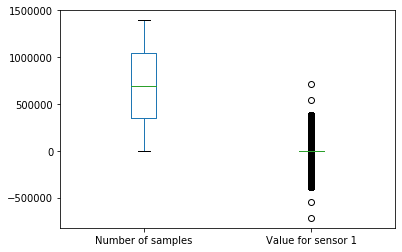

In [16]:
flows_kmeans[['Number of samples', 'Value for sensor 1']].plot(kind='box')

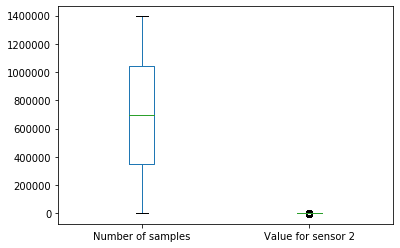

In [17]:
flows_kmeans[['Number of samples', 'Value for sensor 2']].plot(kind='box')

In [18]:
# Convert the flow values to a numpy array
flows_raw1 = flows_kmeans['Value for sensor 1'].values
flows_raw2 = flows_kmeans['Value for sensor 2'].values

In [19]:
# For compatibility with scipy implementation
flows_raw1 = flows_raw1.reshape(-1, 1)
flows_raw1 = flows_raw1.astype('float64')

flows_raw2 = flows_raw2.reshape(-1, 1)
flows_raw2 = flows_raw2.astype('float64')


In [20]:
from sklearn.cluster import KMeans

In [21]:
distortions1 = []
K = range(1,10)
for k in K:
    kMeanModel = KMeans(n_clusters = k)
    kMeanModel.fit(flows_raw1)
    distortions1.append(kMeanModel.inertia_)

In [22]:
distortions2 = []
K = range(1,10)
for k in K:
    kMeanModel = KMeans(n_clusters = k)
    kMeanModel.fit(flows_raw2)
    distortions2.append(kMeanModel.inertia_)

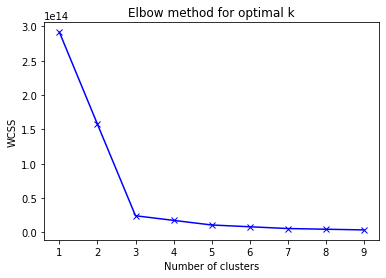

In [23]:
plt.plot(K, distortions1, 'bx-')
plt.title('Elbow method for optimal k')
plt.savefig('ElbowMethod.jpg')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

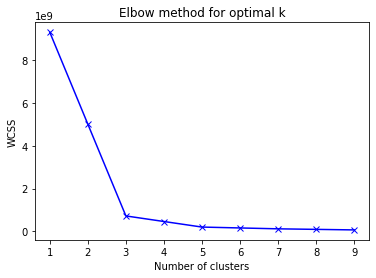

In [24]:
plt.plot(K, distortions2, 'bx-')
plt.title('Elbow method for optimal k')
plt.savefig('ElbowMethod.jpg')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
from scipy.cluster.vq import kmeans, vq

In [26]:
centroids1, avg_distance1 = kmeans(flows_raw1, 3)
centroids2, avg_distance2 = kmeans(flows_raw2, 3)

In [27]:
groups1, cdist1 = vq(flows_raw1, centroids1)
groups2, cdist2 = vq(flows_raw2, centroids2)

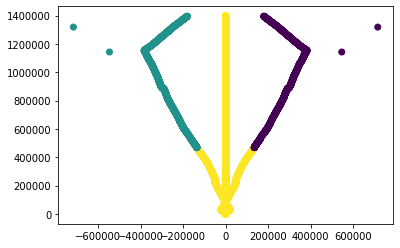

In [28]:
plt.scatter(flows_raw1, np.arange(0,len(flows_raw1)), c=groups1, s=0.5)

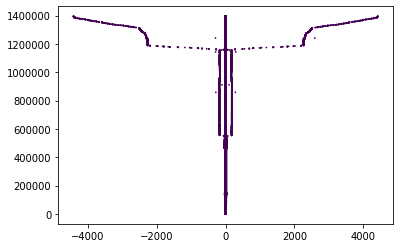

In [29]:
plt.scatter(flows_raw2, np.arange(0,len(flows_raw2)), c=groups2, s=0.5)

In [30]:
#from sklearn.ensemble import IsolationForest
#rs=np.random.RandomState(0)
#clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
#clf.fit(flows_kmeans)
#if_scores = clf.decision_function(flows_kmeans)
#if_anomalies=clf.predict(flows_kmeans)
#if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
#if_anomalies=flows_kmeans[if_anomalies==1]

(array([  2092.,  13885.,   3005.,   8115.,  31953.,  54539., 124281.,
        261048., 465534., 431287.]),
 array([-0.21335672, -0.1791316 , -0.14490648, -0.11068136, -0.07645624,
        -0.04223112, -0.00800601,  0.02621911,  0.06044423,  0.09466935,
         0.12889447]),
 <a list of 10 Patch objects>)

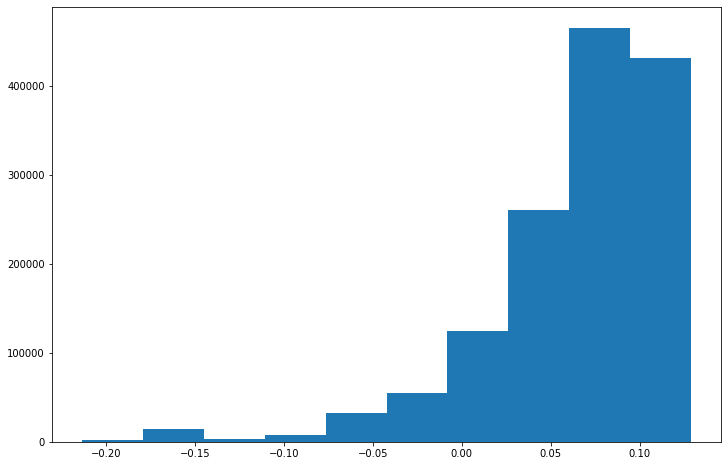

In [31]:
#plt.figure(figsize=(12,8))
#plt.hist(if_scores)

In [32]:
#clf.fit_predict(flows_kmeans)

array([-1, -1, -1, ..., -1, -1, -1])

In [33]:
#np.where(clf.fit_predict(flows_kmeans) == 1)

(array([  16992,   16993,   16994, ..., 1395736, 1395737, 1395738],
       dtype=int64),)

In [34]:
#np.where(clf.fit_predict(flows_kmeans) == -1)

(array([      0,       1,       2, ..., 1395619, 1395620, 1395626],
       dtype=int64),)

In [35]:
#toRemove = np.where(clf.fit_predict(flows_kmeans) == -1)

In [8]:
from datetime import datetime

In [9]:
from dateutil import parser

In [118]:
Winter = flows_data[11023:254001]
Winter

,Times,Total_1,Total_2,Analog_2
11027,2018-12-01 00:00:00,5473.98,0.00,0.78
11028,2018-12-01 00:01:00,5474.41,0.00,0.78
11029,2018-12-01 00:02:00,5474.84,0.00,0.78
11030,2018-12-01 00:03:00,5475.27,0.00,0.78
11031,2018-12-01 00:04:00,5475.70,0.00,0.78
...,...,...,...,...
254000,2019-02-28 23:34:00,134894.75,-23.06,0.77
254001,2019-02-28 23:35:00,134894.98,-23.06,0.77
254002,2019-02-28 23:36:00,134895.20,-23.06,0.77
254003,2019-02-28 23:37:00,134895.45,-23.06,0.77


In [100]:
Spring = flows_data[254002:518656]

In [105]:
Summer = flows_data[518657:784010]

In [102]:
Fall = flows_data[784010: 1044467]

In [126]:
number_of_samples = np.arange(0,len(Winter))
# Winter[['Number of samples', 'Value for sensor 1']].plot(kind='box')

In [127]:
Winter = pd.DataFrame(
    {'Times':Winter['Times'],
     'Flow_1':Winter['Total_1'],
     'Flow_2':Winter['Total_2'],
     'Analog_Flow':Winter['Analog_2'],
     'Number of samples':number_of_samples
    }
)

In [131]:
Winter['Times'] = pd.to_datetime(Winter['Times'], errors = 'coerce')

In [132]:
Winter = Winter.set_index('Times')

In [134]:
Winter_flow_hour = Winter.Flow_1.resample('60T').sum()

In [136]:
Winter_flow_hour['hour'] = Winter_flow_hour.resample('60T').transform('sum')

In [137]:
Winter_flow_hour

Times
2018-12-01 00:00:00                                               329224
2018-12-01 01:00:00                                               330797
2018-12-01 02:00:00                                               332287
2018-12-01 03:00:00                                               333857
2018-12-01 04:00:00                                               335700
                                             ...                        
2019-02-28 22:00:00                                          1.92642e+07
2019-02-28 23:00:00                                           1.6438e+07
2019-03-01 00:00:00                                          1.11812e+07
2019-03-01 01:00:00                                          1.86384e+06
hour                   Times
2018-12-01 00:00:00      329223.66
2018-...
Name: Flow_1, Length: 2163, dtype: object

In [142]:
value_1 = []
Winter['value_1'] = Winter['Flow_1'].shift(-1) - Winter['Flow_1']

In [143]:
Winter['value_1']

Times
2018-12-01 00:00:00    0.43
2018-12-01 00:01:00    0.43
2018-12-01 00:02:00    0.43
2018-12-01 00:03:00    0.43
2018-12-01 00:04:00    0.43
                       ... 
2019-02-28 23:34:00    0.23
2019-02-28 23:35:00    0.22
2019-02-28 23:36:00    0.25
2019-02-28 23:37:00    0.25
2019-02-28 23:38:00     NaN
Name: value_1, Length: 242978, dtype: float64

In [144]:
value_1 = list(Winter['value_1'])[0:-1]

In [145]:
winter_kmeans = pd.DataFrame({
    'Number of samples' : np.arange(0,len(value_1)),
    'Value for sensor 1' : value_1,
})

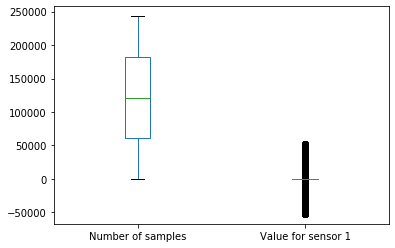

In [147]:
winter_kmeans[['Number of samples', 'Value for sensor 1']].plot(kind='box')

In [148]:
Winter_flow_raw1 = winter_kmeans['Value for sensor 1'].values

In [149]:
Winter_flow_raw1 = Winter_flow_raw1.reshape(-1, 1)
Winter_flow_raw1 = Winter_flow_raw1.astype('float64')

In [150]:
from sklearn.cluster import KMeans

In [151]:
distortions1 = []
K = range(1,10)
for k in K:
    kMeanModel = KMeans(n_clusters = k)
    kMeanModel.fit(Winter_flow_raw1)
    distortions1.append(kMeanModel.inertia_)

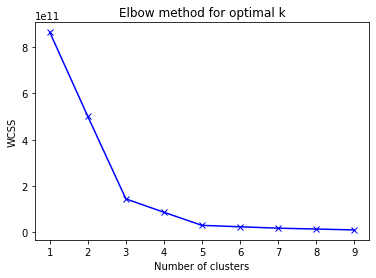

In [153]:
import matplotlib.pyplot as plt
plt.plot(K, distortions1, 'bx-')
plt.title('Elbow method for optimal k')
plt.savefig('ElbowMethod.jpg')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [154]:
from scipy.cluster.vq import kmeans, vq

In [155]:
centroids1, avg_distance1 = kmeans(Winter_flow_raw1, 3)

In [156]:
groups1, cdist1 = vq(Winter_flow_raw1, centroids1)

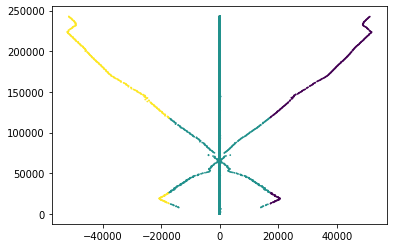

In [159]:
plt.scatter(Winter_flow_raw1, np.arange(0,len(Winter_flow_raw1)), c=groups1, s=0.5)